In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots
from scipy.optimize import curve_fit
from scipy import special
import glob
import os
plt.style.use(['science','notebook','grid'])

In [2]:
from os import listdir
from os.path import isfile, join
mypath = r'C:\\Users\\CR241139\\PHY 3040\\Faisceaux Gaussiens\1 Lentille'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

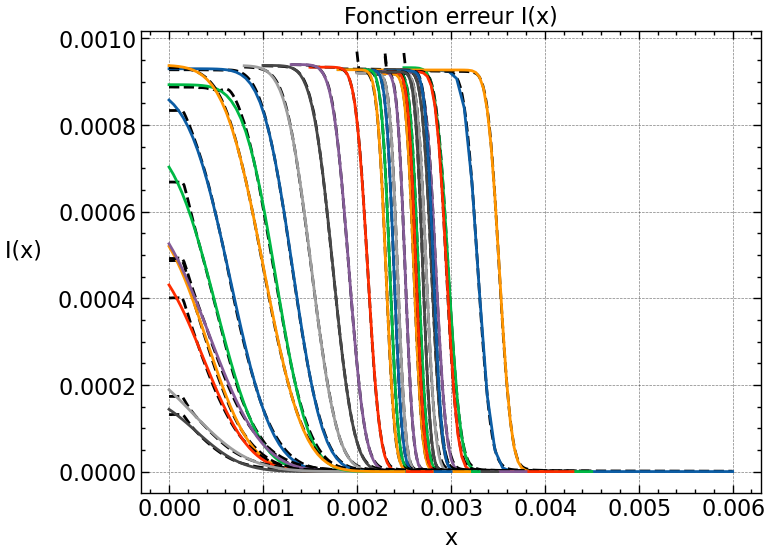

In [3]:
liste_omega_app = []
liste_omega_fit = []
liste_omega_sigma = []

#Nos z
z_int = []

for i in range(len(onlyfiles)):
    if (onlyfiles[i] == '1 Lentille - VF.ipynb') !=  True:
        z_int.append(int(onlyfiles[i][9:]))

z_int= list(np.array(z_int)*10**-2)
z_int = np.vectorize(lambda s:round(s,2))(z_int)



for i in range(len(onlyfiles)) :
    if (onlyfiles[i] == '1 Lentille - VF.ipynb') !=  True:
        df = pd.read_csv(onlyfiles[i],sep="\t",names=['x','I(x)'],header=None,index_col=False)
        df['x']=df['x']*10**-6 #x en m
        
        #Définir la période de décroissance importante pour trouver le x0 de la fonction erreur
        df_fin = df[(abs(df['I(x)'] - max(df['I(x)']))>(0.01/100)) & (abs(df['I(x)'] - min(df['I(x)']))>(0.001/100)) ]
        milieu = (max(df_fin['x']) - min(df_fin['x']))/2
        p0_guess = min(df_fin['x']) + milieu

        #Fonction erreur de I(x)
        def model(x,w,Imax,x0):
            return (Imax/2)*(1-special.erf(((2**0.5)*(x-x0)/w)))

        #Trouver x0 et Imax
        maxI = np.argmax(df["I(x)"])
        Imax = df.loc[maxI][1]

        #90%Imax et 10%Imax
        Imax_90=0.9*Imax
        Imax_10=0.1*Imax

        #Trouver nos points x et I(x) à 10% et 90% de Imax
        liste_I = list(df["I(x)"])

        #90%
        liste_90 = list(abs(liste_I-Imax_90))
        index_90 = liste_90.index(np.min(liste_90))
        x_90=df.loc[index_90][0]
        I_90=df.loc[index_90][1]

        #10%
        liste_10 = list(abs(liste_I-Imax_10))
        index_10 = liste_10.index(np.min(liste_10))
        x_10=df.loc[index_10][0]
        I_10=df.loc[index_10][1]

        #Estimer w avec 1.28*w=x[10]-x[90]
        omega_app=(x_10-x_90)/(1.28)

        #Faire une liste avec les I avant qu'ils ne varient trop pour trouver incertitude sur I(x)
        
        dfr = df[df['I(x)']/max(df['I(x)'])>0.90]        
        sigma_I = (max(dfr['I(x)']) - min(dfr['I(x)']))/2
        df["sigma_I"] = sigma_I


        #Faire le fit

        [omega_fit,Imax_fit,x0_fit],cov = curve_fit(model, df['x'],df['I(x)'],sigma=df["sigma_I"],
                                                p0=[omega_app,max(df['I(x)']),p0_guess],absolute_sigma=True)

        [sigma_w,sigma_I,sigma_x0] = np.sqrt(np.diag(cov))


        #Append

        liste_omega_app.append(omega_app)
        liste_omega_fit.append(omega_fit)
        liste_omega_sigma.append(sigma_w)

        #Montrer le fit

        t=np.linspace(min(df['x']),max(df['x']))
        plt.plot(df['x'],df['I(x)'],'--',color='black',label='data')
        plt.plot(t,model(t,omega_fit,Imax_fit,x0_fit),label='Fit')
        plt.ylabel('I(x)        ',rotation='horizontal')
        plt.xlabel('x')
        plt.title('Fonction erreur I(x)')
        
#Nos résultats des fits de fonction erreur

résultats = pd.DataFrame({'$z$ $(m)$' : z_int,
                          '$\omega_{calculé}$':liste_omega_app,
                          '$\omega_{fit}$':liste_omega_fit,
                          '$\sigma_{fit}$':liste_omega_sigma},index=z_int)

résultats.set_index('$z$ $(m)$',inplace=True)

#Faire le fit pour w(z)

lam = 632*10**-9

#Définition de la fonction w(z)
def model2(z,w0,z0):
    return np.sqrt(w0**2*(1+(((z-z0)*lam)/(np.pi*w0**2))**2))

#On retire les données après 1.1 car elles déstabilise les valeurs pour le fit
z_int2 = z_int[z_int<1.1]

popt,cov = curve_fit(model2, z_int2,résultats[résultats.index < 1.1]["$\omega_{fit}$"],
                     sigma = résultats[résultats.index < 1.1]["$\sigma_{fit}$"],
                                            p0=[0.0004,0.3],absolute_sigma=True)

omega0_fit = popt[0]
z0_fit = popt[1]
sigma_w0 = np.sqrt(np.diag(cov))[0]
sigma_z0 = np.sqrt(np.diag(cov))[1]

#Caractérisation du laser

zr = (np.pi*omega0_fit**2)/lam
sigma_zr = abs((np.pi/lam)*2*omega0_fit*sigma_w0)

b = 2*zr
sigma_b = 2*sigma_zr

theta = np.degrees(lam/(np.pi*omega0_fit))
sigma_theta = np.degrees((lam/np.pi)*sigma_w0*omega0_fit**-2)

laser = [omega0_fit,sigma_w0,z0_fit,sigma_z0,zr,sigma_zr,b,sigma_b,theta,sigma_theta]
laser_col = ['$\omega_{0fit}$','$\sigma_{\omega_{0fit}}$','$z_{0fit}$','$\sigma_{z_{0fit}}$',
             '$z_{R}$','$\sigma_{z_{R}}$','$b$','$\sigma_{b}$','$\theta$','$\sigma_{\theta}$']
col_names = ['Résultats','Variable']
df_laser = pd.DataFrame(list(zip(laser,laser_col)),columns=col_names)
df_laser.set_index('Variable',inplace=True)

Text(0.5, 1.0, '$\\omega$ en fonction de la distance $z$ sur le rail optique')

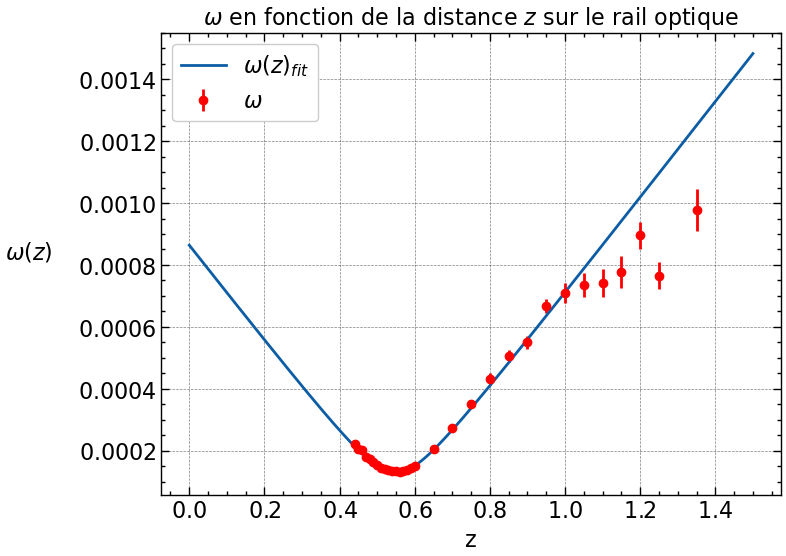

In [4]:
t=np.linspace(0,1.5,1000)
plt.errorbar(z_int,résultats["$\omega_{fit}$"],résultats["$\sigma_{fit}$"],fmt='or',label='$\omega$')
plt.plot(t,model2(t,omega0_fit,z0_fit),label='$\omega(z)_{fit}$')
plt.legend()
plt.xlabel('z')
plt.ylabel('$\omega(z)$             ',rotation='horizontal')
plt.title('$\omega$ en fonction de la distance $z$ sur le rail optique')

In [8]:
df_laser

,Résultats
Variable,
$\omega_{0fit}$,0.000129
$\sigma_{\omega_{0fit}}$,0.000002
$z_{0fit}$,0.549582
$\sigma_{z_{0fit}}$,0.002379
$z_{R}$,0.083294
$\sigma_{z_{R}}$,0.002147
$b$,0.166588
$\sigma_{b}$,0.004294
$\theta$,0.089043


### Complexe


In [13]:
#Notre premier q complexe en position z = 0.145 m donné par 

q0 = 0.145151 + 0.493923j

#Matrice parcourd d
# 1 d
# 0 1
d = 0.3 - 0.145151 #On défini q0 à z = z0 
d2 = np.linspace(0,1,1000) #1m après la lentille

A = 1
B = d 
B2 = d2
C = 0
D = 1

#Matrice lentille mince
# 1 0
# -1/f 1

f = 0.2
Af = 1
Bf = 0
Cf = -1/f
Df = 1



#q1 : q0 parcours distance 0.3 cm - 0.145m

q1 = (A*q0 + B)/(C*q0 + D)

#q2 : q1 traverse lentille mince de 20cm de focale

q2 = (Af * q1 + Bf)/(Cf * q1 + D)

#q3 : q2 qui parcours une distance  d2 de 0 à 1m

q3 = (A*q2 + B2)/(C*q2 + D)

#Trouver les w(z) avec les q3

w3 = np.sqrt(-lam/(np.pi*np.imag(1/q3)))


#Données complexe
w0_complexe = min(w3)
zr_complexe = np.pi*(w0_complexe**2)/lam
b_complexe = 2*zr_complexe
z0_complexe = B2[np.where(w3 == min(w3))[0][0]] + 0.3
theta_complexe = np.degrees(lam/(np.pi*w0_complexe))

laser_complexe = [w0_complexe,z0_complexe,zr_complexe,b_complexe,theta_complexe]
laser_col_complexe = ['$\omega_{0comp}$','$z_{0comp}$','$z_{rcomp}$','$b_{comp}$','$\theta_{comp}$']
col_names_complexe = ['Résultats','Variable']
df_laser_complexe = pd.DataFrame(list(zip(laser_complexe,laser_col_complexe)),columns=col_names)
df_laser_complexe.set_index('Variable',inplace=True)

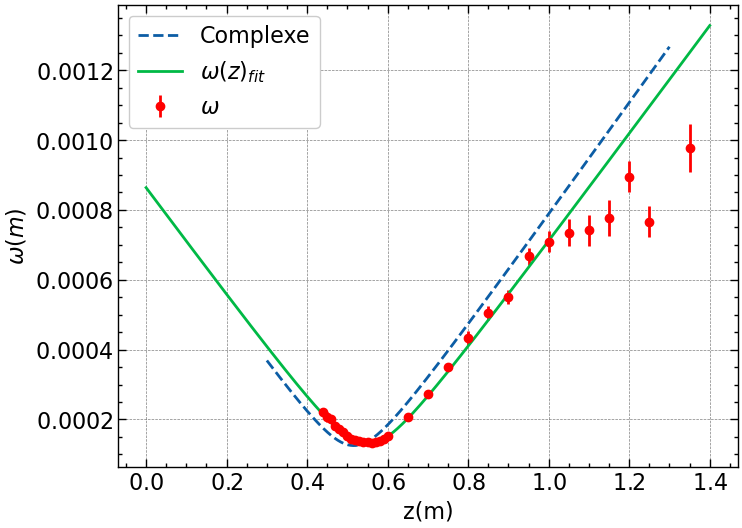

In [14]:
#Le graphique doit prendre en considération que la position de la première lentille à z = 0.3 m
plt.plot(B2 + 0.3,w3,'--',label = 'Complexe')
t=np.linspace(0,1.4,1000)
plt.errorbar(z_int,résultats["$\omega_{fit}$"],résultats["$\sigma_{fit}$"],fmt='or',label='$\omega$')
plt.plot(t,model2(t,omega0_fit,z0_fit),label='$\omega(z)_{fit}$')
plt.legend()
plt.xlabel('z(m)')
plt.ylabel('$\omega(m)$')
plt.savefig('Graph/1 Lentille')

In [15]:
df_laser_complexe

,Résultats
Variable,
$\omega_{0comp}$,0.000125
$z_{0comp}$,0.516216
$z_{rcomp}$,0.077798
$b_{comp}$,0.155596
$\theta_{comp}$,0.092134


In [16]:
df_laser

,Résultats
Variable,
$\omega_{0fit}$,0.000129
$\sigma_{\omega_{0fit}}$,0.000002
$z_{0fit}$,0.549582
$\sigma_{z_{0fit}}$,0.002379
$z_{R}$,0.083294
$\sigma_{z_{R}}$,0.002147
$b$,0.166588
$\sigma_{b}$,0.004294
$\theta$,0.089043


In [43]:
#Pour extra

In [44]:
t2 = np.linspace(0,1.5,1000)
df_1len = pd.DataFrame(list(zip(t2,model2(t2,omega0_fit,z0_fit))))
autre = pd.DataFrame(list(zip(z_int,résultats["$\omega_{fit}$"])))
df_1len = pd.concat([df_1len,autre],axis=1)
df_1len.columns = ['x','y','x1','y1']
df_1len.to_excel(r'C:\\Users\\CR241139\\PHY 3040\\Faisceaux Gaussiens\Extra\df_1len.xlsx')